In [1]:
from utils.models import *

In [2]:
wti = load('data/WTI.csv').pct_change().dropna()
c1 = clean_series('contract_1', wti)
vix = load('data/VIX.csv')
vix_shock = calc_shock('VIX', vix)

In [3]:
window = 36 # number of months for measurement sample
conf_int = .1 # confidence interval (2-tailed)
kf, confs = KF(window=window, conf_int=conf_int).run('contract_1', 'VIX', c1.join(vix_shock).dropna())

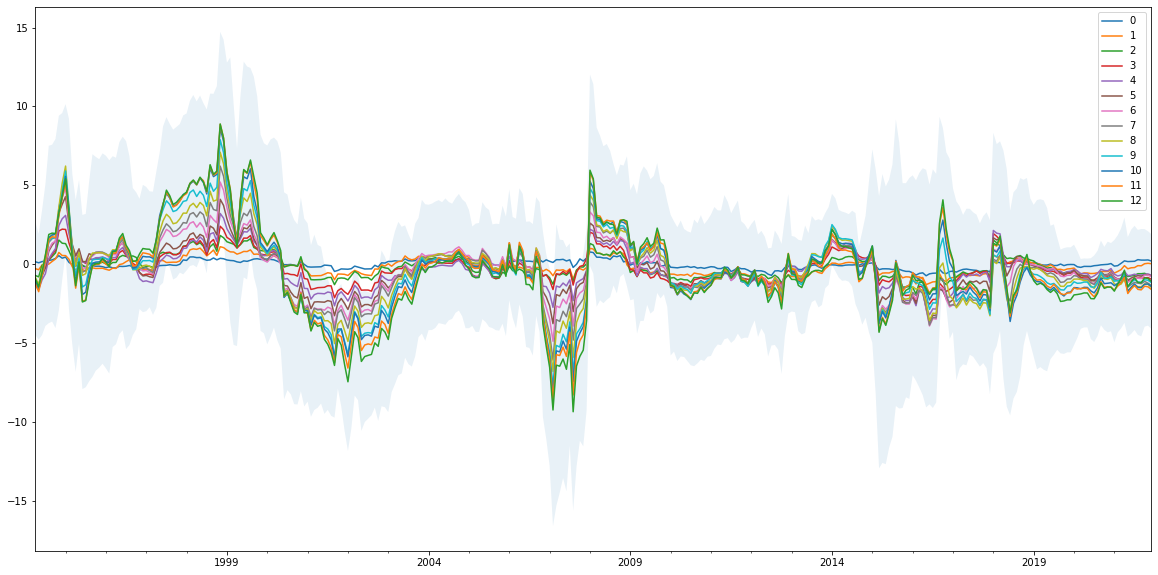

In [4]:
kf.plot(figsize=(20,10))
plt.fill_between(confs.index, confs['lower'], confs['upper'], alpha=0.1)

In [5]:
confs[confs['lower'] > 0] # significant upward movements

,lower,upper
1995-01-01,0.680007,10.144812
1997-07-01,0.069873,9.318378
1998-05-01,0.342623,10.688885
1998-06-01,0.213507,10.204067
1998-08-01,1.798983,10.812678
1998-09-01,0.594101,10.795017
1998-10-01,0.519767,11.282064
1998-11-01,3.050678,14.720813
1998-12-01,1.735314,14.231718
1999-08-01,0.769686,12.434838


In [6]:
confs[confs['upper'] < 0] # significant downward movements

,lower,upper
2001-06-01,-9.482204,-0.045565
2001-07-01,-9.229961,-0.923113
2001-08-01,-9.603609,-1.571199
2001-09-01,-9.724013,-3.104565
2001-10-01,-7.878430,-1.544319
2001-11-01,-8.993996,-1.254419
2001-12-01,-10.549034,-2.163122
2002-01-01,-11.837139,-3.064414
2002-02-01,-10.431202,-1.325195
2002-03-01,-8.321258,-0.231601


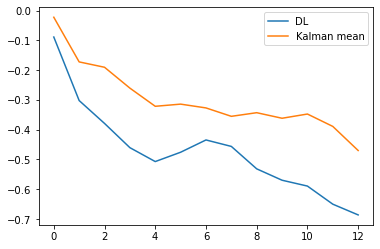

In [7]:
plt.plot(np.cumsum(DL('contract_1', 'VIX', c1.join(vix_shock).dropna().iloc[window:]).model.params[1:]), label='DL')
plt.plot(kf.mean(), label='Kalman mean')
plt.legend()

In [8]:
gpr = load('data/GPRGlobal.csv')
gpr_shock = calc_shock('GPRI', gpr)

In [9]:
kf2, confs2 = KF(window=window, conf_int=conf_int).run('contract_1', 'GPRI', c1.join(gpr_shock).dropna())

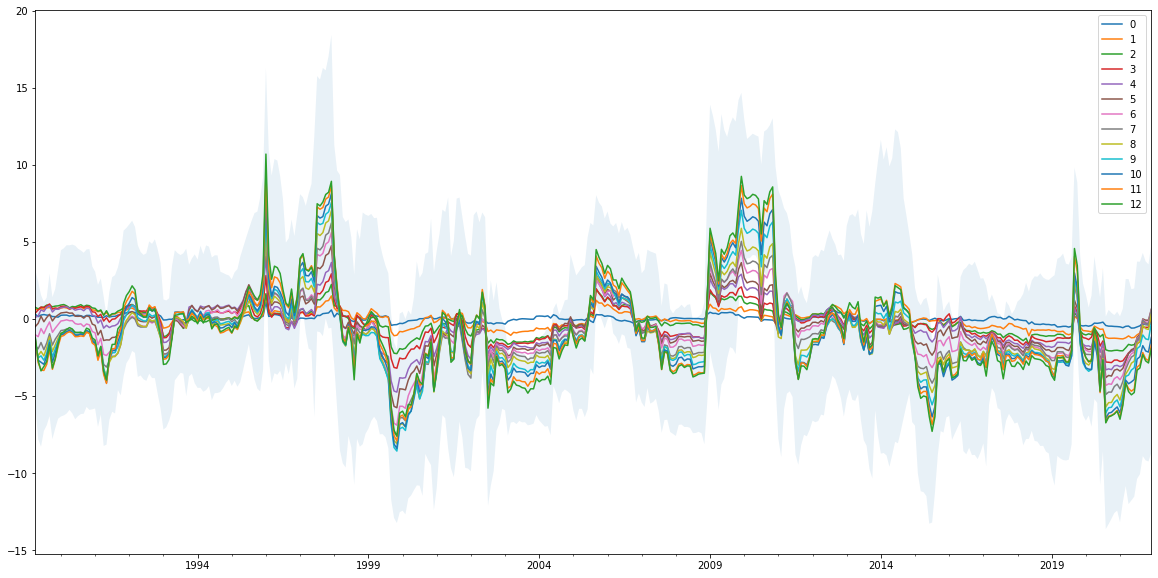

In [10]:
kf2.plot(figsize=(20, 10))
plt.fill_between(confs2.index, confs2['lower'], confs2['upper'], alpha=0.1)

In [11]:
confs2[confs2['lower'] > 0]

,lower,upper
1996-01-01,5.105321,16.262287
1997-02-01,0.563835,7.883719
1997-10-01,0.008193,16.118437
2005-09-01,0.957939,8.017084
2005-10-01,0.417516,7.533309
2006-02-01,0.308774,6.180571
2009-11-01,0.559952,14.183152
2009-12-01,3.819977,14.654961
2010-01-01,3.090368,12.956494
2010-02-01,3.915959,11.666301


In [12]:
confs2[confs2['upper'] < 0]

,lower,upper
1999-10-01,-12.927120,-1.537498
1999-11-01,-13.257612,-1.989759
2000-02-01,-12.692809,-0.024063
2002-12-01,-5.847748,-0.081452
2003-01-01,-5.942337,-0.548278
2003-02-01,-7.570676,-2.038301
2003-03-01,-6.742441,-2.387415
2003-04-01,-6.694784,-1.404054
2003-05-01,-6.836289,-1.785620
2003-06-01,-6.631008,-2.090412


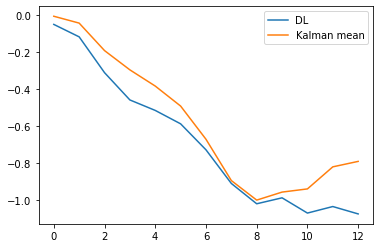

In [13]:
plt.plot(np.cumsum(DL('contract_1', 'GPRI', c1.join(gpr_shock).dropna().iloc[window:]).model.params[1:]), label='DL')
plt.plot(kf2.mean(), label='Kalman mean')
plt.legend()